# Import packages

In [66]:
# !pip install -r multiff_analysis/requirements.txt

In [43]:
%load_ext autoreload
%autoreload 2

import os
import sys

project_folder = '/Users/dusiyi/Documents/Multifirefly-Project'
os.chdir(project_folder)
sys.path.append(os.path.join(project_folder, 'multiff_analysis', 'methods'))

from data_wrangling import general_utils, specific_utils, process_monkey_information
from pattern_discovery import pattern_by_trials, pattern_by_trials, cluster_analysis, organize_patterns_and_features
from visualization.matplotlib_tools import plot_behaviors_utils
from non_behavioral_analysis.neural_data_analysis.get_neural_data import neural_data_processing
from non_behavioral_analysis.neural_data_analysis.visualize_neural_data import plot_neural_data, plot_modeling_result
from non_behavioral_analysis.neural_data_analysis.model_neural_data import cca_class, cca_utils, neural_data_modeling, drop_high_corr_vars, drop_high_vif_vars
from non_behavioral_analysis.neural_data_analysis.neural_vs_behavioral import prep_monkey_data, prep_target_data, neural_vs_behavioral_class
from non_behavioral_analysis.neural_data_analysis.planning_neural import planning_neural_class, planning_neural_utils
from non_behavioral_analysis.neural_data_analysis.decode_targets import behav_features_to_keep, decode_target_class, plot_gpfa_utils, decode_target_utils, fit_gpfa_utils, gpfa_regression_utils

import sys
import math
import gc
import subprocess
from pathlib import Path

# Third-party imports
import numpy as np
from numpy import var
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from scipy import linalg, interpolate
from scipy.signal import fftconvolve
from scipy.io import loadmat
from scipy import sparse
import torch
from numpy import pi
import cProfile
import pstats

# Machine Learning imports
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.cancorr import CanCorr

# Neuroscience specific imports
import neo
import rcca

# To fit gpfa
import numpy as np
from importlib import reload
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process
from elephant.gpfa import GPFA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from elephant.gpfa import gpfa_core, gpfa_util




plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
print("done")


pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get data

In [2]:
#raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0416"
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0328"
dec = decode_target_class.DecodeTargetClass(raw_data_folder_path=raw_data_folder_path,
                                                               bin_width=0.02, window_width=0.05)

In [3]:
dec.streamline_making_behav_and_neural_data(exists_ok=True)
dec.get_x_and_y_var(exists_ok=True)
dec._free_up_memory()
dec.pursuit_data.head(3)

Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0328/ff_dataframe.h5
Retrieved target_df
Loaded behav_data_all from all_monkey_data/decoding_targets/monkey_Bruno/data_0328/behav_data_all.csv
Retrieved target_clust_last_vis_df
Percentage of targets not in a visible cluster out of all targets 64.38582028029678
33817 rows of 179921 rows (18.8%) of behav_data_all are preserved after taking out chunks between target last-seen time and capture time
0 segments (0.0%) out of 781 segments have 0 duration. They are dropped from pursuit data

No NA values found in pursuit_data
Window width changed from 0.05 to 0.06 to make it odd
Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Bruno/data_0328/binned_spikes_df.csv
Loaded x_var_lags and y_var_lags from all_monkey_data/deco

,bin,point_index,monkey_speed,monkey_angle,monkey_dw,monkey_ddw,monkey_ddv,monkey_speeddummy,whether_new_distinct_stop,delta_distance,monkey_x_target_last_seen,monkey_y_target_last_seen,LDy,LDz,RDy,RDz,gaze_mky_view_x_l,gaze_mky_view_y_l,gaze_mky_view_angle_l,gaze_mky_view_x_r,gaze_mky_view_y_r,gaze_mky_view_angle_r,eye_world_speed,valid_view_point_l,valid_view_point_r,...,target_angle_to_boundary,target_rel_x,target_rel_y,time_since_target_last_seen,target_last_seen_distance,target_last_seen_angle,target_last_seen_angle_to_boundary,time_since_last_capture,traj_curv,target_opt_arc_dheading,time_target_last_seen,distance_from_monkey_pos_target_last_seen,cum_distance_since_target_last_seen,d_heading_since_target_last_seen,time,monkey_x,monkey_y,cum_distance,gaze_world_x_l,gaze_world_y_l,gaze_world_x_r,gaze_world_y_r,target_index,target_x,target_y
0,1328,1600,1.53938,-0.16494,0.00000,0.00000,6.97237,1.00000,False,0.02538,-348.36676,681.16382,-77.00000,46.00000,-103.00000,45.00000,5.80012,35.20791,-0.16327,8.39757,37.41921,-0.22076,11.44420,False,False,...,-0.45741,50.86549,80.69285,0.01648,95.40816,-0.56230,-0.45730,1.90892,-0.00373,-0.86477,26.55835,0.02538,0.02538,0.00000,26.57483,-348.34170,681.15979,3225.00842,-314.69370,669.67820,-312.93890,666.75291,2,-277.09608,617.73507
1,1329,1601,20.33766,-0.16494,0.00000,0.00000,12.60664,1.00000,False,0.33667,-348.36676,681.16382,-77.00000,46.00000,-103.00000,45.00000,5.80012,35.20791,-0.16327,8.39757,37.41921,-0.22076,11.44420,False,False,...,-0.45900,50.86733,80.35619,0.03304,95.40816,-0.56230,-0.45730,1.92548,-0.00373,-0.86821,26.55835,0.36205,0.36205,0.00000,26.59139,-348.00931,681.10632,3225.34509,-314.69370,669.67820,-312.93890,666.75291,2,-277.09608,617.73507
2,1330,1602,26.75265,-0.16494,0.00000,-0.00372,8.00479,1.00000,False,0.44471,-348.36676,681.16382,-77.00000,46.00000,-103.00000,45.00000,5.80012,35.20791,-0.16327,8.39757,37.41921,-0.22076,11.44420,False,False,...,-0.46112,50.86970,79.91148,0.04966,95.40816,-0.56230,-0.45730,1.94210,-0.00412,-0.87280,26.55835,0.80676,0.80676,0.00000,26.60801,-347.57025,681.03565,3225.78980,-314.69370,669.67820,-312.93890,666.75291,2,-277.09608,617.73507


In [4]:
dec.x_var_lags.shape

(33125, 243)

In [5]:
dec.y_var_lags.shape

(33125, 651)

# Reduce columns in lags

In [6]:
# dec.reduce_x_var_lags() # this has been shown to not do anything
dec.reduce_y_var_lags()

Loaded cached y_var_lags_reduced from all_monkey_data/decoding_targets/monkey_Bruno/data_0328/decode_target_y_var_lags_reduced.csv


In [7]:
# # get final vif
# vif_df = drop_high_vif_vars.get_vif_df(dec.y_var_lags_reduced)

# GPFA

## get data for GPFA

In [ ]:
dec.single_vis_target_df.columns

In [ ]:
dec.prepare_spikes_for_gpfa()

print(len(dec.spiketrains))
print(len(dec.spiketrains[0]))
print(len(dec.spiketrains[0][2]))

## fit gpfa

In [ ]:
len(dec.spiketrains)

In [ ]:
dec.get_gpfa_traj(latent_dimensionality=10)


In [ ]:
stop!

## plot latent dimensions

In [ ]:
plot_gpfa_utils.plot_gpfa_traj_3d_uniform_color()


In [ ]:
# First, enable interactive mode in your notebook
%matplotlib inline

# Import required modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Create the interactive plot
fig, ax = plot_gpfa_utils.plot_gpfa_traj_3d(
    trajectories=dec.trajectories,
    figsize=(15, 5),
    linewidth_single_trial=0.75,
    alpha_single_trial=0.3,
    linewidth_trial_average=2,
    title='Latent dynamics extracted by GPFA',
    view_azim=-5,
    view_elev=60
)

plt.show()

In [ ]:
# fig = plot_gpfa_utils.plot_gpfa_traj_3d_plotly(trajectories)

In [ ]:
# Find variance explained by each latent dimension
traj_stack = np.stack(dec.trajectories, axis=0)  # shape: (n_trials, 3, T)
var_by_dim = var(traj_stack, axis=(0, 2))    # variance across trials and time
var_by_dim /= var_by_dim.sum()               # normalize to get explained variance ratio
print("Variance explained by each latent dimension:", var_by_dim)


In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(15, 5))

ax.set_title('Latent dynamics extracted by GPFA')
ax.set_xlabel('Time [s]')

average_trajectory = np.mean(, axis=0)
time = np.arange(len(average_trajectory[0])) * 0.02  # assuming all trajectories have the same length

for i, x in enumerate(average_trajectory):
    ax.plot(time, x, label=f'Dim {i+1}')

ax.legend()

plt.tight_layout()
plt.show()


## prepare data for regression

## regression

In [ ]:
dec.common_t_stop = max(dec.spike_segs_df['t_duration']) * pq.s + dec.bin_width_w_unit        

In [ ]:
dec.get_gpfa_and_behav_data_for_all_trials()

In [ ]:
max_timepoints = int(1.5/0.02)
scores_by_time, times = gpfa_regression_utils.time_resolved_regression_variable_length(dec.gpfa_trials, dec.behavior_trials, time_step=0.02, cv_folds=5, max_timepoints=max_timepoints)

In [ ]:
behavior_labels = dec.pursuit_data_by_trial.drop(columns=['segment']).columns
len(behavior_labels)
scores_by_time_df = pd.DataFrame(scores_by_time, columns=behavior_labels)
# see the percentage of 1 of this dummy variable
dec.pursuit_data_by_trial[['whether_new_distinct_stop']].sum()/len(dec.pursuit_data_by_trial)

In [ ]:
gpfa_regression_utils.plot_time_resolved_scores(scores_by_time, times, behavior_labels=behavior_labels)


In [ ]:
trial_counts = np.array([sum(latent.shape[0] > t for latent in gpfa_trials)
                         for t in range(scores_by_time.shape[0])])
plt.plot(times, trial_counts)
plt.xlabel("Time (s)")
plt.ylabel("Trials with data")


# behav features

In [ ]:
# find set difference between dec.behav_data_all.columns and dec.behav_data.columns
diff_columns = set(dec.behav_data_all.columns) - set(dec.behav_data.columns)

In [ ]:
diff_columns

## check result of reducing

In [ ]:
## also check correlations between x vars without lags
high_corr_pair_df, top_n_corr_df = drop_high_corr_vars.get_pairs_of_columns_w_high_corr(
            dec.x_var, corr_threshold=0.8)
top_n_corr_df

# Linear regression (didn't modify yet)

Regressing the behavioral variables individually (as y_var) against all neural activity

## put results in df

In [ ]:
# dec.make_or_retrieve_y_var_lr_resault_df(exists_ok=True)
dec.y_var_lr_result_df = neural_data_modeling.get_y_var_lr_result_df(
                dec.x_var_lags_reduced, dec.y_var)
dec.y_var_lr_result_df.head(5)

##  plot all neural clusters vs one behavioral var

In [ ]:
# drop existing columns involving bin (most likely there's only one or zero after being reduced, because different lags of bins can have very high correlations)
bin_cols = [col for col in dec.y_var_lags_reduced.columns if 'bin' in col]
dec.y_var_lags_reduced.drop(columns=bin_cols, inplace=True)

# then we add the variable bin (so that only the 0 lag is used)
dec.y_var_lags_reduced['bin'] = dec.y_var_lags['bin_0'].astype(int)

In [ ]:


# conduct linear regression on X and y
plt.rcParams["figure.figsize"] = (20, 10)
bins_to_plot = dec.y_var_lags_reduced['bin'].values
for i, column in enumerate(dec.y_var_lags_reduced.columns):

    plot_neural_data.plot_regression(dec.y_var_lags_reduced, column, dec.x_var_lags_reduced, bins_to_plot=bins_to_plot, min_r_squared_to_plot=0.3)
    # if i == 3:
    #     break

##  plot one neural cluster vs one behavioral var

In [ ]:
# plot one neural cluster against one behavioral variable
cluster_num, behavioral_column = 6, 'monkey_speed'
bins_to_plot = range(1000, 1200)
x_values = dec.binned_spikes_df.loc[bins_to_plot, f'unit_{cluster_num}'].values
y_values = dec.pursuit_data[behavioral_column][bins_to_plot]
reg = LinearRegression().fit(x_values.reshape(-1, 1), y_values)

plt.scatter(x_values, y_values, color='blue', s=1)
plt.plot(x_values, reg.predict(x_values.reshape(-1, 1)), color='red', linewidth=1)
plt.show()

# CCA

https://medium.com/@pozdrawiamzuzanna/canonical-correlation-analysis-simple-explanation-and-python-example-a5b8e97648d2

## No lagging

In [52]:
cca_no_lag = cca_class.CCAclass(X1=dec.x_var, X2=dec.y_var_reduced, lagging_included=False)

Training CCA, kernel = None, regularization = 0.0000, 10 components
Canonical Correlation Per Component Pair: [0.38926 0.26684 0.1724  0.1552  0.10962 0.09902 0.0924  0.08253 0.07302
 0.06748]
% Shared Variance: [0.15152 0.0712  0.02972 0.02409 0.01202 0.0098  0.00854 0.00681 0.00533
 0.00455]


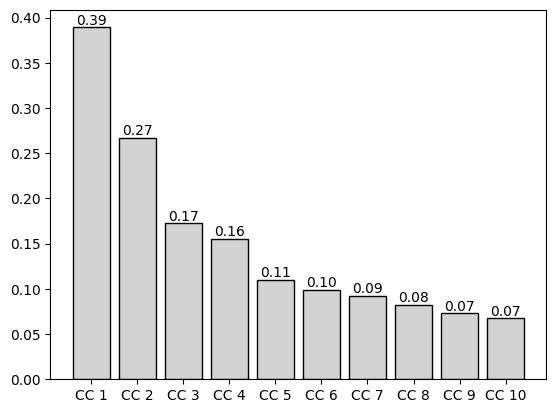

In [53]:
cca_no_lag.conduct_cca()

## with lags

In [14]:
cca_lags = cca_class.CCAclass(X1=dec.x_var_lags.drop(columns='bin'), X2=dec.y_var_lags_reduced, lagging_included=True)
print(f'dec.x_var_lags.shape: {dec.x_var_lags.shape}')
print(f'dec.y_var_lags_reduced.shape: {dec.y_var_lags_reduced.shape}')

dec.x_var_lags.shape: (33125, 243)
dec.y_var_lags_reduced.shape: (33125, 115)


Training CCA, kernel = None, regularization = 0.0000, 10 components
Canonical Correlation Per Component Pair: [0.68786 0.43551 0.40293 0.27123 0.25526 0.1962  0.18183 0.17427 0.1594
 0.14827]
% Shared Variance: [0.47315 0.18967 0.16235 0.07357 0.06516 0.03849 0.03306 0.03037 0.02541
 0.02198]


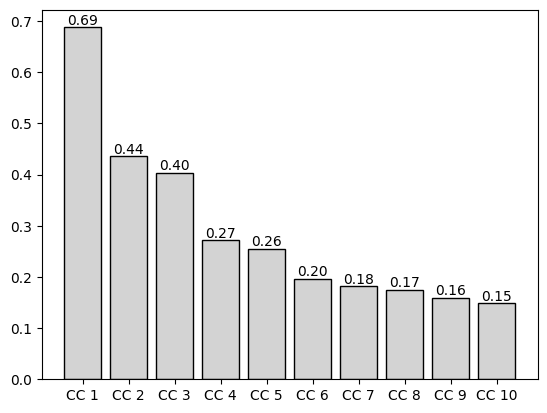

In [15]:
cca_lags.conduct_cca()

In [11]:
df_path = os.path.join(
    dec.decoding_targets_folder_path, 'decode_target_y_var_lags_reduced.csv') 
dec.y_var_lags_reduced.to_csv(df_path, index=False)

# but optimize the code by AI

In [12]:
dec.reduce_y_var_lags()

Loaded cached y_var_lags_reduced from all_monkey_data/decoding_targets/monkey_Bruno/data_0328/decode_target_y_var_lags_reduced.csv


In [ ]:
gc.collect()

4820

## compare lag vs no lag

In [ ]:
canon_df = pd.DataFrame(cca_no_lag.canon_corr, columns = ['no_lag'])
canon_df[f'lag_{dec.max_lag_number}'] = cca_lags.canon_corr
canon_df['component'] = [f'CC {i+1}' for i in range(cca_lags.n_components)]
# convert canon_df to long format
canon_df_long = pd.melt(canon_df, id_vars=['component'], var_name='lag', value_name='canon_coeff')

In [ ]:
# make a sns bar plot on canon_df_long
plt.figure(figsize=(8, 6))
sns.barplot(x='component', y='canon_coeff', data=canon_df_long, hue='lag')
plt.show()

## cca_inst (choose one between lags and no lag)

In [54]:
# choose no lag
cca_inst = cca_no_lag

In [45]:
# choose lags
cca_inst = cca_lags

## loadings

### neurons

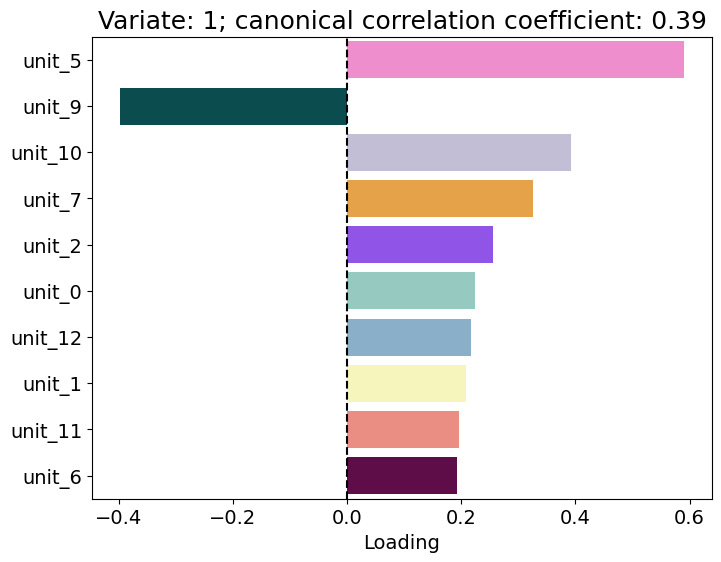

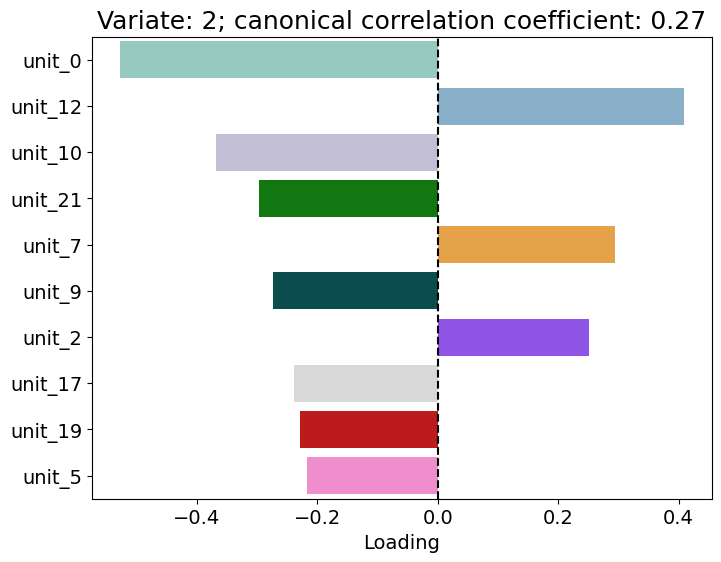

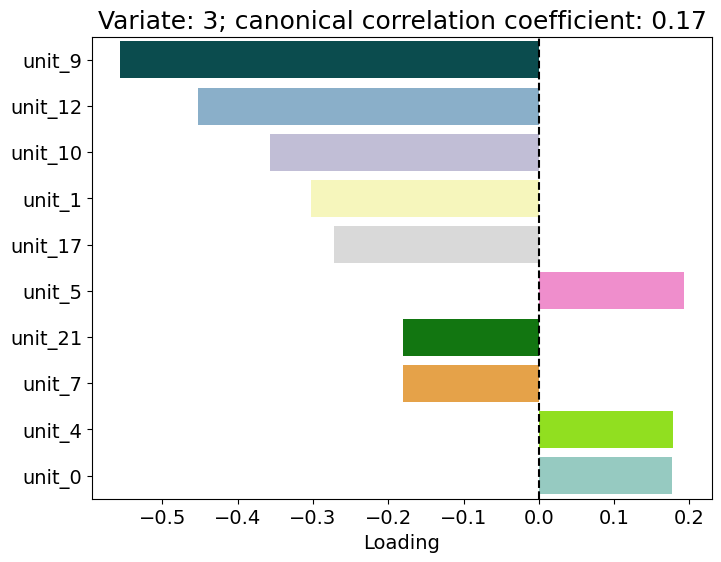

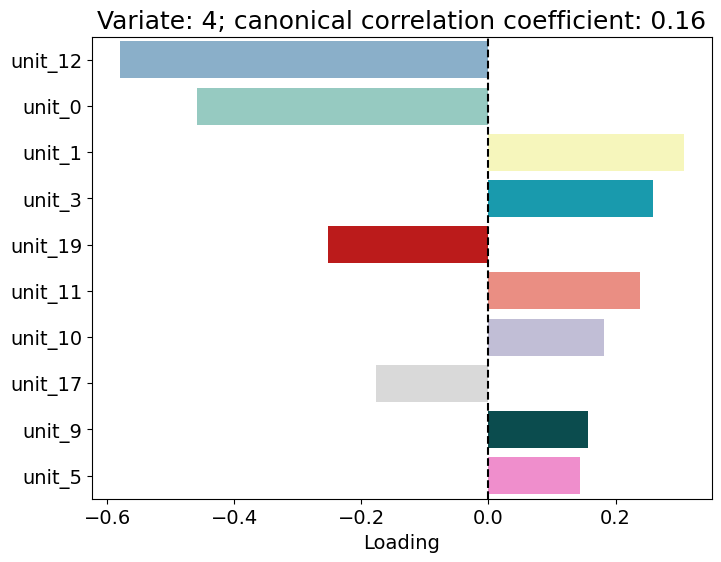

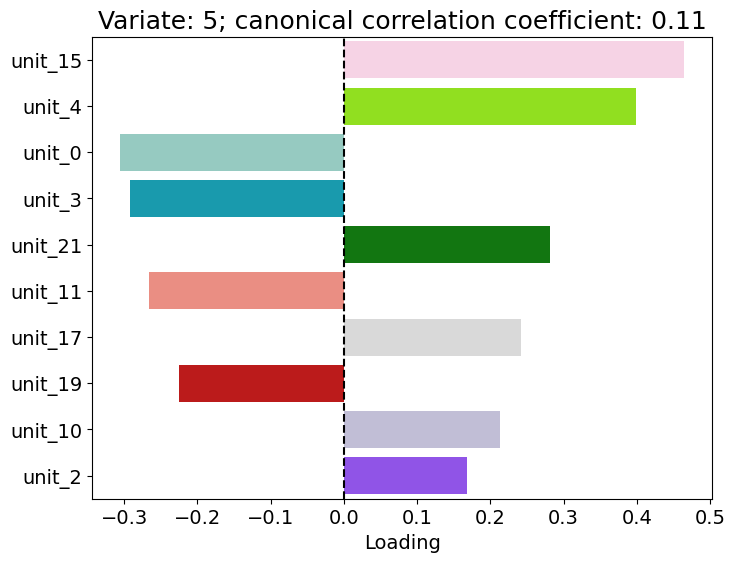

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X1', squared=False)

### behavior

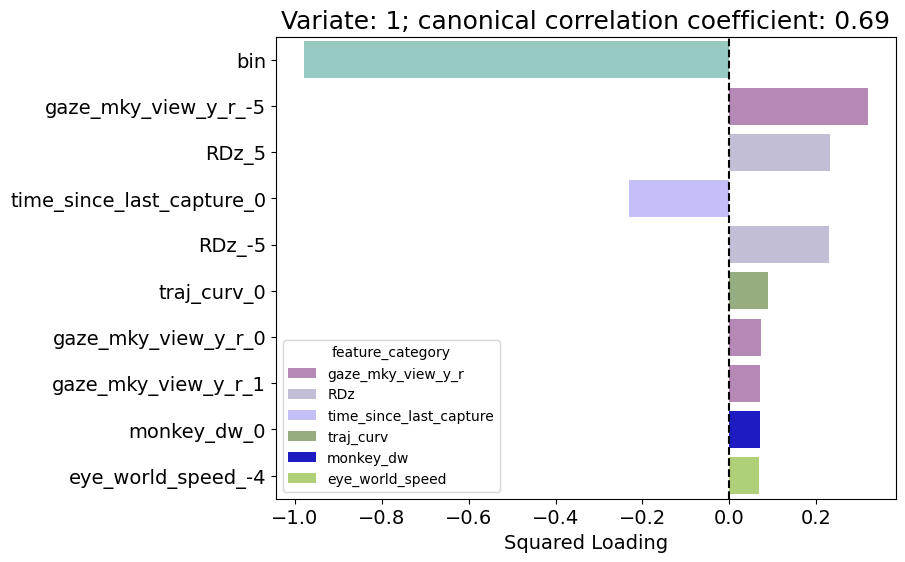

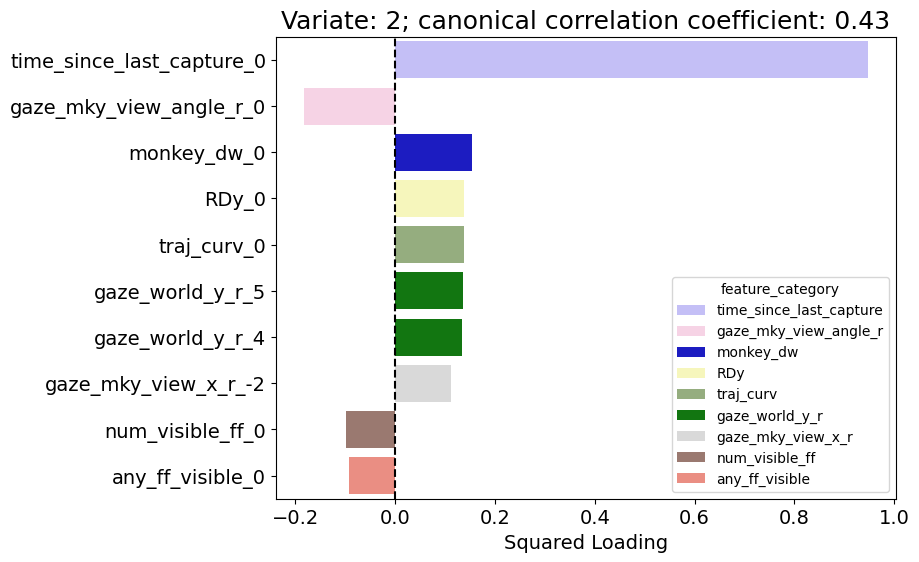

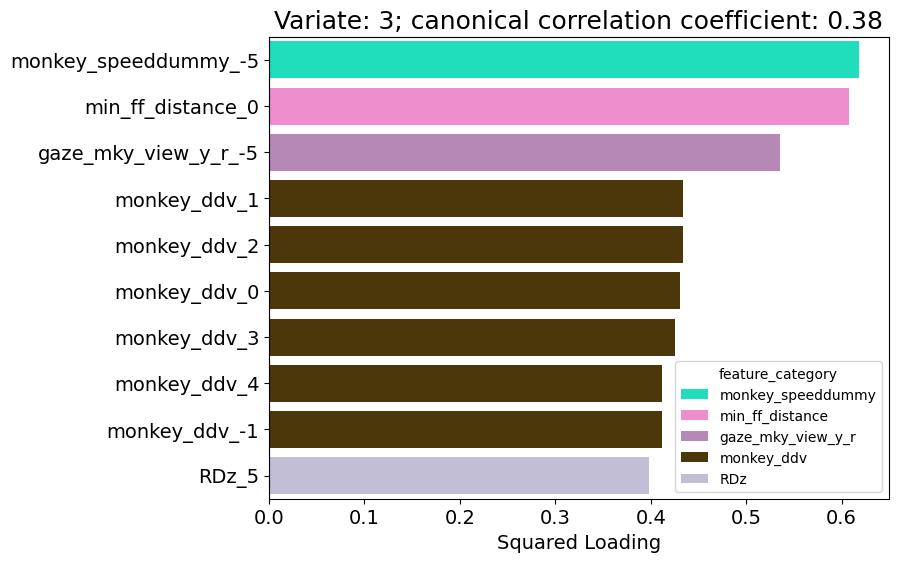

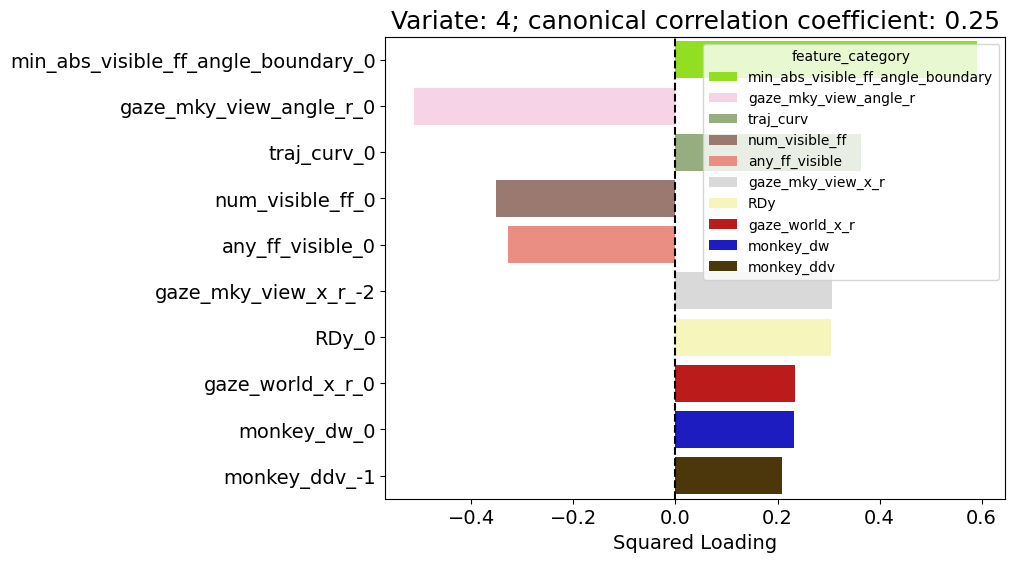

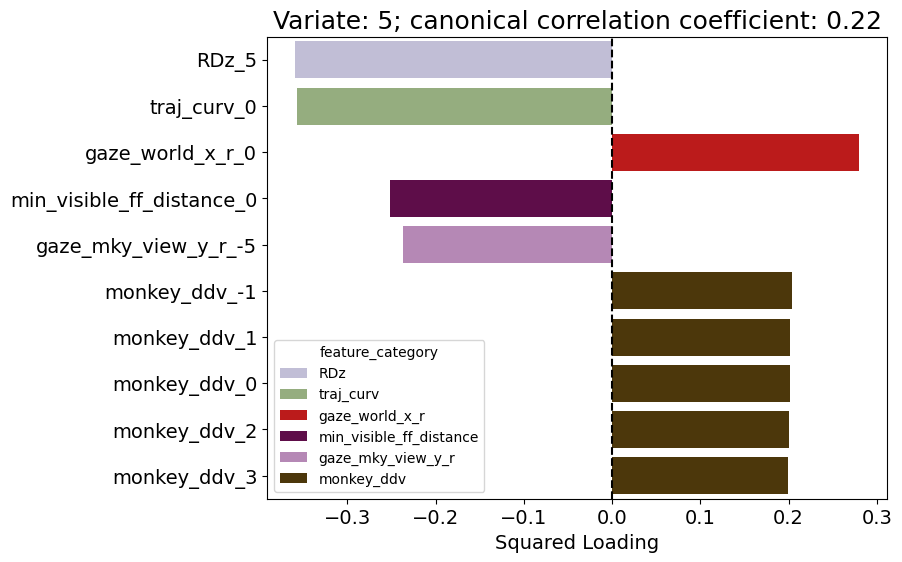

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X2', squared=False)

## squared loadings

### neurons

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X1')

### behavior

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X2')

## abs weights ranked

### neurons

In [ ]:
cca_inst.plot_ranked_weights()

### behavior

In [ ]:
cca_inst.plot_ranked_weights(X1_or_X2='X2')

## plot real weights

### neurons

In [ ]:
cca_inst.plot_ranked_weights(abs_value=False)

### behavior

In [ ]:
cca_inst.plot_ranked_weights(X1_or_X2='X2', abs_value=False)

In [ ]:
stop here!

## distribution of each feature

In [ ]:
cca_inst.X2_sc.shape

In [ ]:
X2_sc_df = pd.DataFrame(cca_inst.X2_sc, columns = cca_inst.X2.columns)
X2_sc_df.describe()

In [ ]:
for column in X2_sc_df.columns:
    plt.figure(figsize=(8, 2))
    sns.boxplot(X2_sc_df[column], orient='h')
    plt.show()
    

## heatmap of weights
raw canonical coefficients are interpreted in a manner analogous to interpreting regression coefficients. For example: a one unit increase in reading leads to a .0446 decrease in the first canonical variate of set 2 when all of the other variables are held constant (in some other data)

In [ ]:
weight_df = cca_inst.X2_weight_df.copy()
weight_df = weight_df.set_index('feature').drop(columns='feature_category')

In [ ]:
plt.subplots(figsize=(15, 25))
sns.heatmap(weight_df.iloc[:20, :10], cmap='coolwarm', annot=True, linewidths=1)
plt.show()

## test for p values

In [58]:
stats_cca = CanCorr(cca_inst.X1_sc, cca_inst.X2_sc)
print(stats_cca.corr_test().summary())
neural_data_modeling.print_weights('X', stats_cca.x_cancoef)
neural_data_modeling.print_weights('Z', stats_cca.y_cancoef)

                              Cancorr results
   Canonical Correlation Wilks' lambda   Num DF     Den DF   F Value Pr > F
---------------------------------------------------------------------------
0                 0.3893        0.6970 1298.0000 682503.3204  9.2815 0.0000
1                 0.2668        0.8215 1218.0000 653794.9262  5.3678 0.0000
2                 0.1724        0.8845 1140.0000 624899.3335  3.5742 0.0000
3                 0.1552        0.9116 1064.0000 595809.1790  2.8862 0.0000
4                 0.1096        0.9341  990.0000 566517.0233  2.2836 0.0000
5                 0.0990        0.9455  918.0000 537015.4172  2.0256 0.0000
6                 0.0924        0.9548  848.0000 507296.9858  1.8072 0.0000
7                 0.0825        0.9630  780.0000 477354.5353  1.6002 0.0000
8                 0.0730        0.9696  714.0000 447181.1884  1.4307 0.0000
9                 0.0675        0.9748  650.0000 416770.5534  1.2989 0.0000
10                0.0642        0.9793  58

## compute explained variance

In [ ]:
cca2.compute_ev([test1, test2])

Computing explained variance for component #1
Computing explained variance for component #2
Computing explained variance for component #3
Computing explained variance for component #4
Computing explained variance for component #5
Computing explained variance for component #6
Computing explained variance for component #7
Computing explained variance for component #8
Computing explained variance for component #9
Computing explained variance for component #10


[array([[0.09692, 0.04037, 0.10917, 0.22626, 0.06211, 0.25198, 0.03315,
         0.00877, 0.1624 , 0.39486, 0.08081, 0.21686, 0.0971 , 0.17194,
         0.11917, 0.2579 , 0.56396, 0.07233, 0.29674, 0.09529, 0.18368,
         0.0371 ],
        [0.14486, 0.26294, 0.27188, 0.47096, 0.06344, 0.02482, 0.24925,
         0.20454, 0.25213, 0.11392, 0.07079, 0.38173, 0.11225, 0.3563 ,
         0.30776, 0.31347, 0.70438, 0.05697, 0.46837, 0.14215, 0.38992,
         0.03915],
        [0.03092, 0.14446, 0.32482, 0.39929, 0.04024, 0.02336, 0.19697,
         0.26144, 0.20617, 0.13955, 0.114  , 0.44138, 0.22128, 0.33769,
         0.24369, 0.36466, 0.70381, 0.11683, 0.47478, 0.17861, 0.33785,
         0.19381],
        [0.33721, 0.46702, 0.63866, 0.80577, 0.35632, 0.39184, 0.51143,
         0.60656, 0.43066, 0.34417, 0.55315, 0.77979, 0.36286, 0.62393,
         0.5876 , 0.6039 , 1.25276, 0.43788, 0.94991, 0.59286, 0.70278,
         0.52336],
        [0.07849, 0.24694, 0.41605, 0.44415, 0.07048, 0.1639

In [ ]:
stop pls

# train test split

## w lags

In [ ]:
train1, test1, train2, test2 = train_test_split(cca_inst.X1_sc, cca_inst.X2_sc, test_size=0.3, random_state=42)
# use training and testing set
nComponents = 10
cca2 = rcca.CCA(kernelcca = False, reg = 0., numCC = nComponents)
cca2.train([train1, train2])

traincorrs = cca2.validate([train1, train2])
testcorrs = cca2.validate([test1, test2])

Training CCA, kernel = None, regularization = 0.0000, 10 components


[array([ 0.11325,  0.02171,  0.02412,  0.02011,  0.01308,  0.17395,
         0.0211 ,  0.01809,  0.0059 ,  0.12581,  0.08184,  0.04423,
         0.13778,  0.0178 ,  0.00788,  0.01497,  0.00053,  0.03123,
         0.00266,  0.02026,  0.03216,  0.03481,  0.08739,  0.04274,
         0.02483,  0.02788,  0.01465,  0.18984,  0.01656,  0.05076,
         0.03031,  0.10724,  0.10688,  0.06671,  0.04615,  0.04336,
         0.03486,  0.02401,  0.     ,  0.02058,  0.00768,  0.01525,
         0.0147 ,  0.01206,  0.0843 ,  0.05462,  0.03829,  0.01048,
         0.01411,  0.186  ,  0.01198,  0.04812, -0.00036,  0.08538,
         0.08929,  0.03924,  0.09756,  0.05352,  0.01793,  0.01859,
        -0.00017,  0.02795,  0.00481,  0.00855,  0.01491,  0.00687,
         0.08042,  0.0557 ,  0.02216,  0.02235,  0.02803,  0.16607,
         0.01241,  0.06015,  0.01356,  0.08912,  0.14021,  0.02237,
         0.05819,  0.0315 ,  0.0024 ,  0.0214 , -0.00546,  0.03061,
         0.00148,  0.02512,  0.00129,  0.03451, 

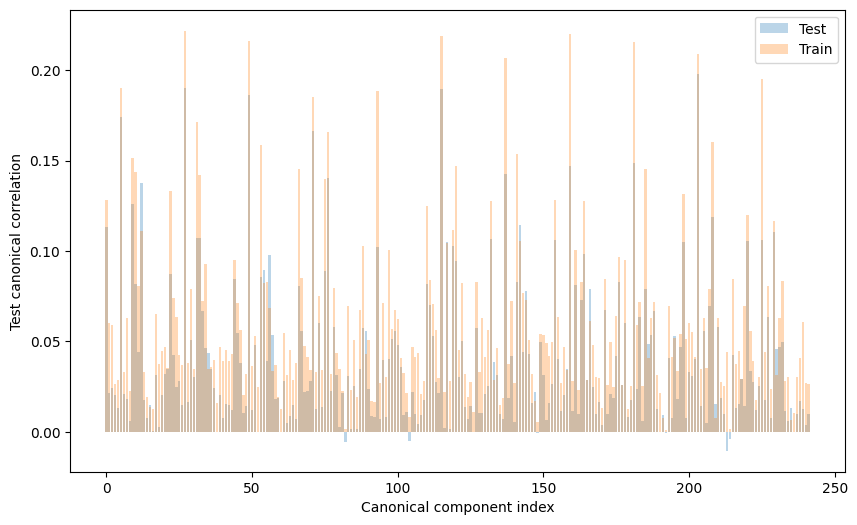

In [51]:
cca_utils.plot_cca_prediction_accuracy_train_test_bars(traincorrs, testcorrs)

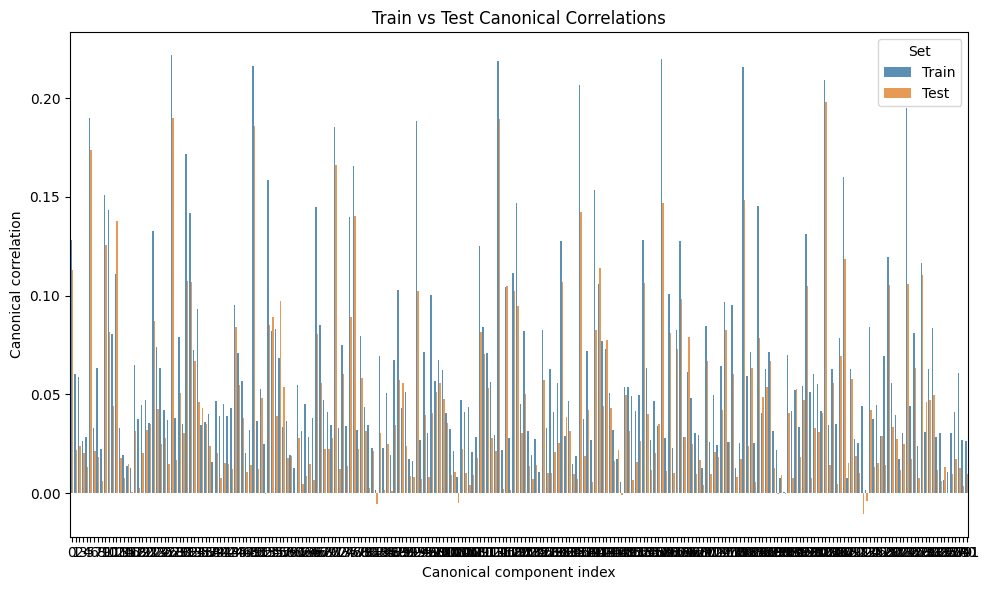

In [ ]:
cca_utils.plot_cca_prediction_accuracy_train_test_stacked_bars(traincorrs, testcorrs)

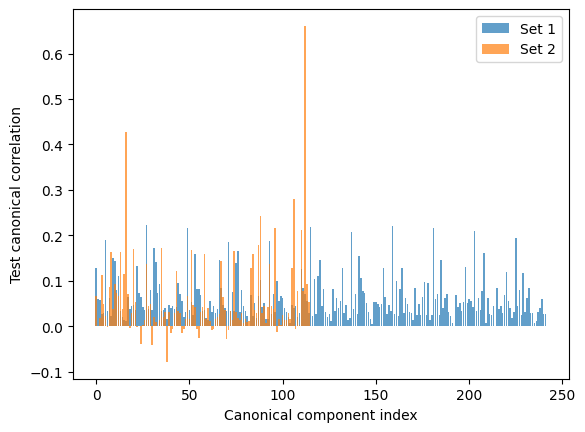

In [47]:
cca_utils.plot_cca_prediction_accuracy_bars(traincorrs)

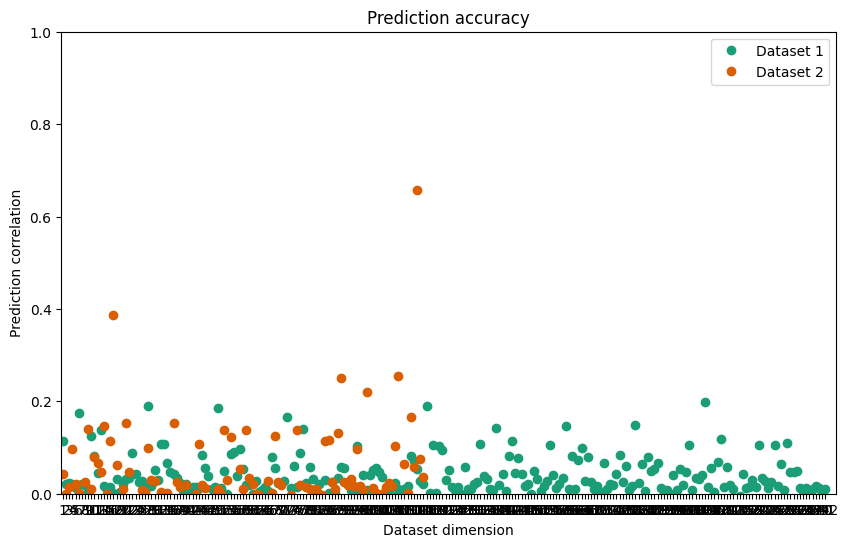

In [52]:
cca_utils.plot_cca_prediction_accuracy_scatter(testcorrs)

# PGAM (unfinished)

In [ ]:
## Categorize variables
dec.y_var_reduced.columns
temporal_vars = ['time_rel_to_stop',
 'time_when_nxt_ff_first_seen_rel_to_stop',
 'time_when_cur_ff_first_seen_rel_to_stop',
 'time_when_nxt_ff_last_seen_rel_to_stop',
 'time_when_cur_ff_last_seen_rel_to_stop',
 ]

spatial_vars = [x for x in dec.y_var_reduced.columns if x not in temporal_vars]
spatial_vars

# Inspect data

## sparsity of neural data

In [ ]:
dec.binned_spikes_df.shape

In [ ]:
# inspect neural data

bins = dec.binned_spikes_df

# Calculate percentage of non-zero rows for each column
non_zero_percentages = (bins != 0).mean() * 100

# Create a DataFrame with the results
non_zero_df = pd.DataFrame({
    'Column': non_zero_percentages.index,
    'Percent_Non_Zero': non_zero_percentages.values
})

# Sort by percentage in descending order
non_zero_df = non_zero_df.sort_values('Percent_Non_Zero', ascending=False)

print("Percentage of non-zero values in each column:")
print(non_zero_df)


In [ ]:
bins.drop(columns='bin').mean(axis=1).describe()

# plot the percentile of values of mean firing rates across neurons at each time bin
mean_rates = bins.drop(columns='bin').mean(axis=1)

# Calculate percentiles from 0 to 100
percentiles = np.arange(0, 101, 1)
percentile_values = np.percentile(mean_rates, percentiles)

# Create plot
plt.figure(figsize=(6, 4))
plt.plot(percentiles, percentile_values)
plt.xlabel('Percentile')
plt.ylabel('Mean Firing Rate')
plt.title('Distribution of Mean Firing Rates Across Neurons')
plt.grid(True)
plt.show()


## multicollinearity

### y var (behavioral)

In [ ]:
y_var_vif = drop_high_vif_vars.get_vif_df(dec.y_var)
print(y_var_vif.head(8))

# calculate the correlation coefficient among the columns with VIF > 5
# specific_columns = vif_df[vif_df['vif'] > 5].feature.values
specific_columns = y_var_vif.feature.values[:10]
corr_coeff = dec.y_var[specific_columns].corr()
#plt.figure(figsize = (6, 6))
plt.figure(figsize = (8, 6))
sns.heatmap(corr_coeff, cmap='coolwarm', annot=True, linewidths=1, vmin=-1)
plt.show()

In [ ]:
# Try y_var_reduced

y_var_vif = drop_high_vif_vars.get_vif_df(dec.y_var_reduced)
print(y_var_vif.head(8))

# calculate the correlation coefficient among the columns with VIF > 5
# specific_columns = vif_df[vif_df['vif'] > 5].feature.values
specific_columns = y_var_vif.feature.values[:10]
corr_coeff = dec.y_var[specific_columns].corr()
#plt.figure(figsize = (6, 6))
plt.figure(figsize = (8, 6))
sns.heatmap(corr_coeff, cmap='coolwarm', annot=True, linewidths=1, vmin=-1)
plt.show()

## plot trial segments in pursuit_data

In [ ]:
from visualization.matplotlib_tools import plot_trials,
dec.make_PlotTrials_args()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]                     

max_plot_to_make = 2
plot_counter = 0

for index, row in dec.single_vis_target_df.iloc[2:].iterrows():

    duration = [row['last_vis_time'], row['ff_caught_time']]

    returned_info = plot_trials.PlotTrials(
                duration, 
                *dec.PlotTrials_args,  
                adjust_xy_limits=True,       
                minimal_margin=50,
                show_reward_boundary=True,
                show_alive_fireflies=False,
                show_visible_fireflies=True,
                show_in_memory_fireflies=True,
                show_believed_target_positions=True,
                )
    plt.show()
    

    plot_counter += 1
    if plot_counter >= max_plot_to_make:
        break

### check target_rel_x and y
(The look correct after checking)

In [ ]:
pursuit_sub = dec.pursuit_data.loc[dec.pursuit_data['target_index']==65].copy()
pursuit_sub['target_angle_deg'] = pursuit_sub['target_angle'] * 180/pi 

In [ ]:
pursuit_sub[['point_index', 'target_angle_deg', 'target_distance', 'target_rel_x', 'target_rel_y']]

# Reducing columns in lags: experiment

## check for contributions

In [ ]:
df = dec.y_var_lags_reduced.copy()
# for target_feature in vif_df[vif_df['vif'] > 5].feature.values:
for index, row in vif_df.iterrows():
    target_feature = row.feature
    print(f'\n\n {target_feature}: VIF = {row.vif}')
    contributions = drop_high_vif_vars.check_vif_contribution(df, target_feature)



 monkey_speeddummy_-5: VIF = 8.6

Top 15 contributors to multicollinearity for 'monkey_speeddummy_-5':
whether_new_distinct_stop_-5   0.24485
monkey_dw_0                    0.18092
whether_new_distinct_stop_-4   0.16895
traj_curv_0                    0.16000
whether_new_distinct_stop_-3   0.13172
whether_new_distinct_stop_-2   0.10793
whether_new_distinct_stop_4    0.10138
whether_new_distinct_stop_5    0.09477
whether_new_distinct_stop_3    0.09425
whether_new_distinct_stop_-1   0.09339
catching_ff_-3                 0.09200
catching_ff_-4                 0.08715
catching_ff_-2                 0.08598
catching_ff_-1                 0.08093
whether_new_distinct_stop_0    0.07577
dtype: float64


 gaze_mky_view_y_r_-5: VIF = 7.2

Top 15 contributors to multicollinearity for 'gaze_mky_view_y_r_-5':
gaze_mky_view_x_r_-2      0.37224
gaze_mky_view_angle_r_0   0.26973
min_ff_distance_0         0.22794
bin                       0.18287
RDz_-5                    0.17440
RDy_0               

## check subset's vif

### use y_var_lags

In [ ]:
columns = [col for col in dec.y_var_lags.columns if ('LD' in col) or (
                'RD' in col) or ('gaze_mky_view_angle' in col)]

df_sub = dec.y_var_lags[columns].copy()
print(df_sub.columns)
sub_vif = drop_high_vif_vars.get_vif_df(df_sub)
sub_vif

Index(['LDy_0', 'LDz_0', 'RDy_0', 'RDz_0', 'gaze_mky_view_angle_l_0',
       'gaze_mky_view_angle_r_0', 'LDy_-1', 'LDz_-1', 'RDy_-1', 'RDz_-1',
       'gaze_mky_view_angle_l_-1', 'gaze_mky_view_angle_r_-1', 'LDy_1',
       'LDz_1', 'RDy_1', 'RDz_1', 'gaze_mky_view_angle_l_1',
       'gaze_mky_view_angle_r_1', 'LDy_-2', 'LDz_-2', 'RDy_-2', 'RDz_-2',
       'gaze_mky_view_angle_l_-2', 'gaze_mky_view_angle_r_-2', 'LDy_2',
       'LDz_2', 'RDy_2', 'RDz_2', 'gaze_mky_view_angle_l_2',
       'gaze_mky_view_angle_r_2', 'LDy_-3', 'LDz_-3', 'RDy_-3', 'RDz_-3',
       'gaze_mky_view_angle_l_-3', 'gaze_mky_view_angle_r_-3', 'LDy_3',
       'LDz_3', 'RDy_3', 'RDz_3', 'gaze_mky_view_angle_l_3',
       'gaze_mky_view_angle_r_3', 'LDy_-4', 'LDz_-4', 'RDy_-4', 'RDz_-4',
       'gaze_mky_view_angle_l_-4', 'gaze_mky_view_angle_r_-4', 'LDy_4',
       'LDz_4', 'RDy_4', 'RDz_4', 'gaze_mky_view_angle_l_4',
       'gaze_mky_view_angle_r_4', 'LDy_-5', 'LDz_-5', 'RDy_-5', 'RDz_-5',
       'gaze_mky_view_angle_

,feature,vif
42,LDy_-4,157.50000
30,LDy_-3,141.00000
18,LDy_-2,139.50000
12,LDy_1,134.30000
6,LDy_-1,132.00000
...,...,...
51,RDz_4,12.10000
9,RDz_-1,11.90000
21,RDz_-2,11.80000
63,RDz_5,9.10000


### use y_var_lags_reduced

In [ ]:
# columns = [col for col in dec.y_var_lags_reduced.columns if ('LD' in col) or (
#                 'RD' in col) or ('gaze_mky_view_angle' in col)]

columns = [col for col in dec.y_var_lags_reduced.columns if ('x_r' in col) or ('y_r' in col)]

df_sub = dec.y_var_lags_reduced[columns].copy()
print(df_sub.columns)
sub_vif = drop_high_vif_vars.get_vif_df(df_sub)
sub_vif

Index(['gaze_mky_view_x_r_0', 'gaze_world_y_r_0', 'gaze_mky_view_x_r_-1',
       'gaze_world_y_r_-1', 'gaze_mky_view_x_r_1', 'gaze_world_y_r_1',
       'gaze_mky_view_x_r_-2', 'gaze_mky_view_y_r_-2', 'gaze_world_x_r_-2',
       'gaze_world_y_r_-2', 'gaze_mky_view_x_r_2', 'gaze_world_x_r_2',
       'gaze_world_y_r_2', 'gaze_mky_view_x_r_-3', 'gaze_mky_view_y_r_-3',
       'gaze_world_x_r_-3', 'gaze_world_y_r_-3', 'gaze_mky_view_x_r_3',
       'gaze_world_y_r_3', 'gaze_mky_view_x_r_-4', 'gaze_mky_view_y_r_-4',
       'gaze_world_x_r_-4', 'gaze_world_y_r_-4', 'gaze_mky_view_x_r_4',
       'gaze_world_y_r_4', 'gaze_mky_view_x_r_-5', 'gaze_mky_view_y_r_-5',
       'gaze_world_x_r_-5', 'gaze_world_y_r_-5', 'gaze_mky_view_x_r_5',
       'gaze_world_x_r_5', 'gaze_world_y_r_5'],
      dtype='object')


,feature,vif
11,gaze_world_x_r_2,4.80000
30,gaze_world_x_r_5,4.50000
12,gaze_world_y_r_2,3.10000
22,gaze_world_y_r_-4,3.00000
16,gaze_world_y_r_-3,3.00000
10,gaze_mky_view_x_r_2,3.00000
29,gaze_mky_view_x_r_5,2.90000
9,gaze_world_y_r_-2,2.80000
27,gaze_world_x_r_-5,2.70000
31,gaze_world_y_r_5,2.60000


## exp on subsets to reduce

In [ ]:
dec.reduce_y_var_lags(filter_vif_by_feature=False)


====================Dropping lags of features with high correlation for each feature====================
Processing feature 1/59
9 columns of *min_ff_distance* dropped: [-4, -3, -2, -1, 0, 1, 2, 3, 4]
8 columns of *target_opt_arc_dheading* dropped: [-4, -3, -2, -1, 1, 2, 3, 4]
9 columns of *min_abs_visible_ff_angle* dropped: [-4, -3, -2, -1, 0, 1, 2, 3, 4]
9 columns of *monkey_x_target_last_seen* dropped: [-5, -4, -3, -2, -1, 1, 2, 3, 4]
10 columns of *monkey_angle* dropped: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]
9 columns of *traj_curv* dropped: [-4, -3, -2, -1, 0, 1, 2, 3, 4]
9 columns of *min_visible_ff_distance* dropped: [-4, -3, -2, -1, 0, 1, 2, 3, 4]
10 columns of *monkey_y* dropped: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]
Processing feature 11/59
9 columns of *cum_distance_since_target_last_seen* dropped: [-5, -4, -3, -2, -1, 1, 2, 3, 4]
10 columns of *point_index* dropped: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]
10 columns of *monkey_x* dropped: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]
9 colu

In [ ]:
subset_key_words, all_column_subsets = dec.get_subset_key_words_and_all_column_subsets_for_vif(
            dec.y_var_lags_reduced)
subset_key_words

# Appendix

## check NA

In [ ]:
na_rows, na_cols = general_utils.find_rows_with_na(dec.y_var)
duplicate_rows = general_utils.find_duplicate_rows(dec.y_var, column_subset=None)

# test speed of code

In [ ]:
# Run profiler and save output to file
cProfile.run('dec.streamline_making_behav_and_neural_data()', 'profile_output')

# Load stats and sort by total time
p = pstats.Stats('profile_output')
p.strip_dirs().sort_stats('tottime').print_stats(10)

Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Schro/data_0416/ff_dataframe.h5
Retrieved target_df
Loaded behav_data_all from all_monkey_data/decoding_targets/monkey_Schro/data_0416/behav_data_all.csv
Retrieved target_clust_last_vis_df
Percentage of targets not in a visible cluster out of all targets 61.48936170212767
10752 rows of 179947 rows (6.0%) of behav_data_all are preserved after taking out chunks between target last-seen time and capture time
0 segments (0.0%) out of 289 segments have 0 duration. They are dropped from pursuit data

No NA values found in pursuit_data
Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Schro/data_0416/binned_spikes_df.csv
Wed Jun 11 22:58:41 2025    profile_output

         483900 function calls (470607 primitive calls) in 5.379 seco

In [ ]:
p.strip_dirs().sort_stats('tottime').print_stats()

Wed Jun 11 20:14:40 2025    profile_output

         150862 function calls (147709 primitive calls) in 13.055 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      297    8.237    0.028    8.237    0.028 {method 'searchsorted' of 'numpy.ndarray' objects}
        6    2.314    0.386    2.389    0.398 c_parser_wrapper.py:222(read)
        1    0.668    0.668    9.875    9.875 neural_data_processing.py:83(_make_all_binned_spikes)
      252    0.273    0.001    0.281    0.001 take.py:120(_take_nd_ndarray)
      136    0.222    0.002    0.222    0.002 {method 'nonzero' of 'numpy.ndarray' objects}
       86    0.108    0.001    8.490    0.099 histograms.py:678(histogram)
       30    0.103    0.003    0.204    0.007 managers.py:2276(_merge_blocks)
       24    0.099    0.004    0.099    0.004 shape_base.py:219(vstack)
       86    0.098    0.001    0.098    0.001 necompiler.py:977(re_evaluate)
      147    0.080    0.001    8.241

## See sizes of biggest variables

### in dec

In [ ]:
from pympler import asizeof

sizes = []
for attr in dir(dec):
    if attr.startswith('__') and attr.endswith('__'):
        continue  # skip dunder attributes
    try:
        val = getattr(dec, attr)
        size = asizeof.asizeof(val)
        sizes.append((attr, size))
    except Exception:
        pass  # ignore any errors

# Sort and display largest attributes in MB
for name, size in sorted(sizes, key=lambda x: x[1], reverse=True):
    print(f"{name}: {size / (1024 * 1024):.2f} MB")


### global

In [ ]:
import types
import warnings
from pympler import asizeof

warnings.filterwarnings("ignore", category=UserWarning)


filtered = {
    k: v for k, v in globals().items()
    if not isinstance(v, types.ModuleType)
}

sizes = []
for name, val in filtered.items():
    try:
        sizes.append((name, asizeof.asizeof(val)))
    except:
        pass

for name, size in sorted(sizes, key=lambda x: x[1], reverse=True)[:20]:
    print(f"{name}: {size / (1024 * 1024):.2f} MB")


## more columns (possibly get in the future)

get also get: (but to be honest, it doesn't make that much sense to get them....so let's skip for now.)
'distance traversed since target last visible',
'd angle since target last visible', 'target_at_right',
'time_till_capture', 'time from last visible to capture

Note that there might be multicollinearity. For example, duration from last visible to capture = time since target last visible + time till capture

Similarly, target angle = target angle last seen frozen - d angle since target last visible

(For distance it's not exactly the same because of the difference between distance and distance traversed, but it's still similar)

The multicollinearity is fine in linear regression (when each feature here is a y var), but need to be dealt with in cca.

## other thoughts

should i actually align each section, as if they are trials???
maybe i can try both that and continuous time... both can shed light on different behavioral variables
but for aligning trials, it may require alignment or warping since trial durations vary.

btw, what does it mean stitch data?

also, what does it look like to use RNN to model it?
I thought about the paper that Noah presented on


btw.......IME

## why ratio of bin/target_index approaches constant

In [ ]:
trial_lengths = dec.pursuit_data[['target_index', 'bin']].groupby('target_index').count()
trial_lengths.describe()

In [ ]:
sub = dec.y_var_reduced[['time', 'bin', 'target_index']]
sub['factor'] = dec.y_var_reduced['bin']/dec.y_var_reduced['target_index']
sub

In [ ]:
plt.hist(np.diff(dec.ff_caught_T_sorted), bins=30)
plt.xlabel('Time difference')
plt.ylabel('Count')
plt.title('Distribution of time differences between caught events')
plt.show()


In [ ]:
dec.ff_caught_T_sorted/np.arange(len(dec.ff_caught_T_sorted))

## compared with neural_data_modeling

In [ ]:
dec = neural_vs_behavioral_class.NeuralVsBehavioralClass(raw_data_folder_path=raw_data_folder_path)
dec.streamline_preparing_neural_and_behavioral_data()

In [ ]:
dec.final_behavioral_data

In [ ]:
dec.y_var

In [ ]:
dec.y_var_reduced

In [ ]:
dec.y_var.columns

In [ ]:
dec.y_var_reduced.columns

In [ ]:
[col for col in dec.y_var.columns if col not in dec.y_var_reduced.columns]

In [ ]:
[col for col in dec.y_var_reduced.columns if col not in dec.y_var.columns]

## Check gpfa's binned spikes vs my own binned spikes

In [ ]:
spike_segs_df = fit_gpfa_utils.make_spike_segs_df(dec.spike_df, dec.single_vis_target_df)


### get binned spikes (seqs) from gpfa_utils.

In [ ]:
seg_index = 9
cluster_index = 12
seg = dec.spiketrain_corr_segs[seg_index]
cluster = dec.spike_segs_df.cluster.unique()[cluster_index]

spiketrain = dec.spiketrains[seg_index][cluster_index]
seqs = gpfa_util.get_seqs([spiketrain], dec.bin_width_w_unit)

### take out my own binned spikes

In [ ]:
p_sub = dec.pursuit_data_all[dec.pursuit_data_all['segment']==seg]
binned_spikes_sub = dec.binned_spikes_df[dec.binned_spikes_df['bin'].isin(p_sub['bin'])].copy()
binned_spikes_sub['bin'] = binned_spikes_sub.index
binned_spikes_sub2 = binned_spikes_sub.merge(p_sub[['bin', 'time']], on='bin', how='left')
binned_spikes_sub3 = binned_spikes_sub2[['bin', 'time', f'unit_{cluster}']].copy()

### compare

In [ ]:
trial_length = len(binned_spikes_sub3)
if dec.align_at_beginning:
    binned_spikes_sub3['gpfa'] = seqs[0][1][0][trial_length:]
else:
    binned_spikes_sub3['gpfa'] = seqs[0][1][0][-trial_length:] # when getting latent dimension for neural data, [-trial_length:] was also used
binned_spikes_sub3['same'] = binned_spikes_sub3[f'unit_{cluster}'] == binned_spikes_sub3['gpfa']
binned_spikes_sub3[binned_spikes_sub3['same']!=True]

## find out why there are rows of NA in dec.y_var

In [ ]:
na_rows, na_cols = general_utils.find_rows_with_na(dec.y_var)
duplicate_rows = general_utils.find_duplicate_rows(dec.y_var, column_subset=None)

In [ ]:
dec.behav_data_all.loc[118189:118195, ['bin', 'time', 'target_rel_x', 'target_rel_y','time_since_target_last_seen', 'target_last_seen_distance']]

## Compare old and new target df

In [ ]:
target_df_ori = pd.read_csv('/Users/dusiyi/Documents/Multifirefly-Project/all_monkey_data/patterns_and_features/monkey_Schro/data_0416/target_df_ori.csv')
df = target_df_ori[['target_index', 'point_index', 'time']].copy()
for col in ['target_distance', 'time_since_target_last_seen']:
    df[f'old_{col}'] = target_df_ori[col]   
    df[f'new_{col}'] = dec.target_df[col]  

df['old_target_last_seen_distance'] = target_df_ori['target_last_seen_distance_frozen']
df['new_target_last_seen_distance'] = dec.target_df['target_last_seen_distance']

df2 = df.loc[10068:]
df2

In [ ]:
df3 = df2[df2['point_index']>= 139910]
df3

In [ ]:
139913